Previously we discussed how the discrete momentum operator differs from the [continuum](https://znswanderer.github.io/physics/Discrete-Dispersion/)
and how to use the Fast Fourier Transform (FFT) and linear operators to construct efficient 
[continuous momentum operators](https://znswanderer.github.io/physics/Efficiancy/).

In this post, we will summarize these discussions and illustrate them with 1d, 2d and 3d examples. to have a clear reference point for later.

The one-particle Hamilton operator is of the form

$$
\hat H = \frac{1}{2m} \hat p^2 + V(\hat r) \, ,
$$

where $V(\hat r)$ is the potential energy. The operators $\hat p$ and $\hat r$ can be in 1d, 2d or 3d space.

Usually in this blog we are working in position space, where the $\hat r$ operators are diagonal.
But because $p$ and $r$ do not commute, $[\hat r_i, \hat p_j] = i \hbar \delta_{ij}$, the 
momentum operator is not diagonal in position space and there is no basis in which
both operators can be diagonal at the same time. This means one usually takes a 
approximation for $\hat p$ in discretized space.

The momentum operator in position space is proportional to the first derivative and for $\hat p^2$ 
we get

$$
\hat p_x^2 = - \hbar^2 \frac{\partial^2}{{\partial x}^2} \, .
$$

The [discretized approximation](https://znswanderer.github.io/physics/Discrete/) is then 

$$
\psi'' = \mathbf{D_2} \psi = 
\frac{1}{{\Delta x}^2}
\begin{pmatrix}
-2 & 1 & 0 & 0 &  1 \\
1 & -2 & 1 & 0 &  0 \\
0 & 1 & -2 & 1 &  0 \\
0 & 0 & 1 & -2 & 1  \\
1 & 0 & 0 & 1 & -2  
\end{pmatrix}
\begin{pmatrix}
\psi_0 \\
\psi_1 \\
\psi_2 \\
\psi_3 \\
\psi_4 
\end{pmatrix}
$$

### Eigendecomposition

Another way we can construct the momentum operator in position space is by employing
[eigendecomposition](https://en.wikipedia.org/wiki/Eigendecomposition_of_a_matrix#Eigendecomposition_of_a_matrix).
Here an operator/matrix $\mathbf{A}$ is separated into three operations:

$$
\mathbf{A} = \mathbf{Q} \mathbf{\Lambda_A} \mathbf{Q}^{-1}
$$

The transformation $\mathbf{Q}^{-1}$ from the embedding basis to the eigenbasis of the operator, 
the diagonalized operation $\mathbf{\Lambda_A}$ of the operator in its eigenbasis and finally
the re-transformation $\mathbf{Q}$ into the embedding basis.

In our case the two basis are the position basis and the momentum basis and the transformation
operations $\mathbf{Q}^{-1}$ and $\mathbf{Q}$ can be done by using FFT.

## Implementation as Linear Operators

The operators/matrices $\mathbf{Q}^{-1}$ and $\mathbf{Q}$ can be defined as linear operators in python:

In [1]:
import numpy as np
from types import SimpleNamespace
from scipy import integrate, sparse
from scipy.sparse import kron
import matplotlib.pyplot as plt
from scipy.sparse.linalg import aslinearoperator

In [2]:
plt.style.use(['science', 'notebook', 'grid', 'vibrant'])
plt.rcParams['figure.figsize'] = [6, 4]
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
class Q_inv_1d(sparse.linalg.LinearOperator):

    def __init__(self, N):
        super().__init__(dtype='complex128', shape=(N, N))
        
    def _matvec(self, v):
        return np.fft.fft(v)
    
class Q_1d(sparse.linalg.LinearOperator):

    def __init__(self, N):
        super().__init__(dtype='complex128', shape=(N, N))
        
    def _matvec(self, v):
        return np.fft.ifft(v)

### 1d Systems

With this we can define the Hamiltonian for the [simple harmonic oscillator](https://znswanderer.github.io/physics/Harmonic-Oscillator-SymPy/):

In [4]:
def SHO_1d(N, L, mass=1, hbar=1, omega=2*np.pi):
    # potential energy
    x = np.linspace(-L/2, L/2, N, endpoint=False)
    R2 = sparse.diags([x**2], [0])
    V = aslinearoperator(0.5 * mass * omega**2 * R2)

    # kinetic energy
    k = 2 * np.pi * np.fft.fftfreq(N, L/N)
    D2_k = sparse.diags([-k**2], [0])
    D2 = Q_1d(N) @ aslinearoperator(D2_k) @ Q_inv_1d(N)
    T = -(hbar**2 / (2 * mass)) * D2

    H = T + V
    
    return SimpleNamespace(**locals())

The eigenvalues are more or less identical to the analytic solution even for a
small resolution of $N=30$:

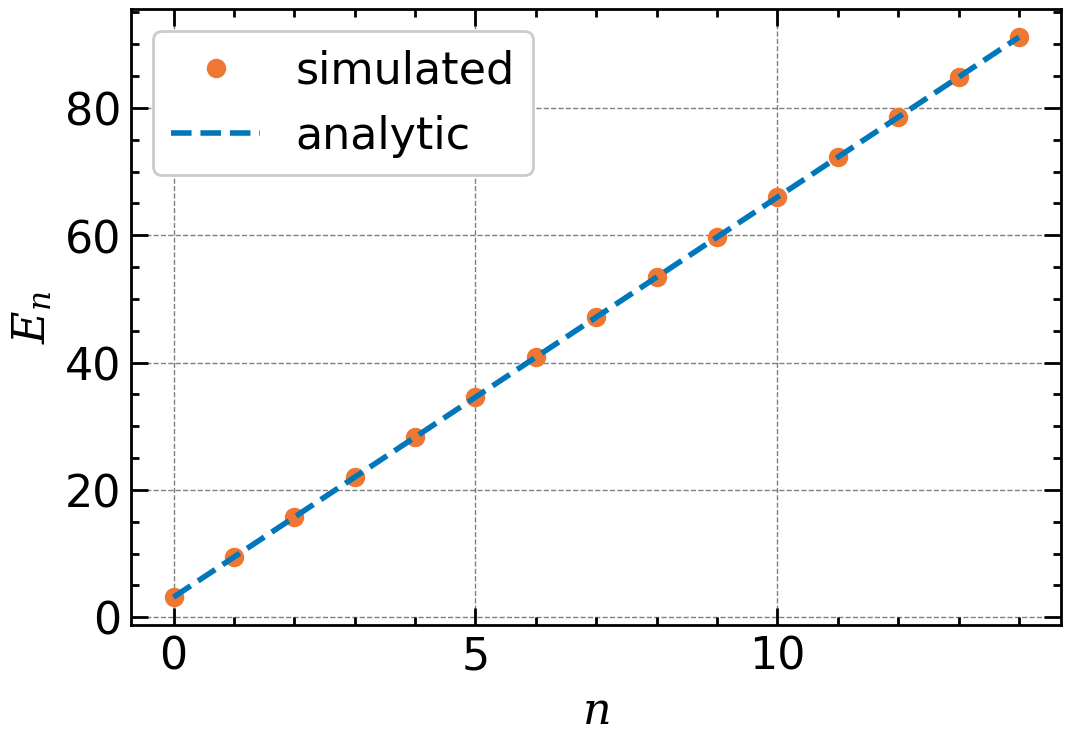

In [5]:
s = SHO_1d(N=30, L=6)
eigs, eigv = sparse.linalg.eigsh(s.H, k=15, which='SM')
eigs = np.sort(eigs)
plt.plot(eigs, 'o', label="simulated")
plt.plot(s.hbar * s.omega * np.arange(0.5, 15.5), '--', label="analytic")
plt.xlabel("$n$")
plt.ylabel("$E_n$")
plt.legend();

If on the other hand we take the usual non-diagonal version of the momentum operator:

In [6]:
def SHO_1d_nd(N, L, mass=1, hbar=1, omega=2*np.pi):
    # potential energy
    x = np.linspace(-L/2, L/2, N, endpoint=False)
    R2 = sparse.diags([x**2], [0])
    V = 0.5 * mass * omega**2 * R2

    # kinetic energy
    dx = np.diff(x)[0]
    D2 = sparse.diags([1, -2, 1, 1, 1], [-1, 0, 1, N-1, -N+1], shape=(N, N)) / dx**2
    T = -(hbar**2 / (2 * mass)) * D2

    H = T + V
    
    return SimpleNamespace(**locals())

The eigenvalues differ significantly from the analytic solution for $N=30$ and we will 
need at least a resolution of $N=100$ for similar quality:

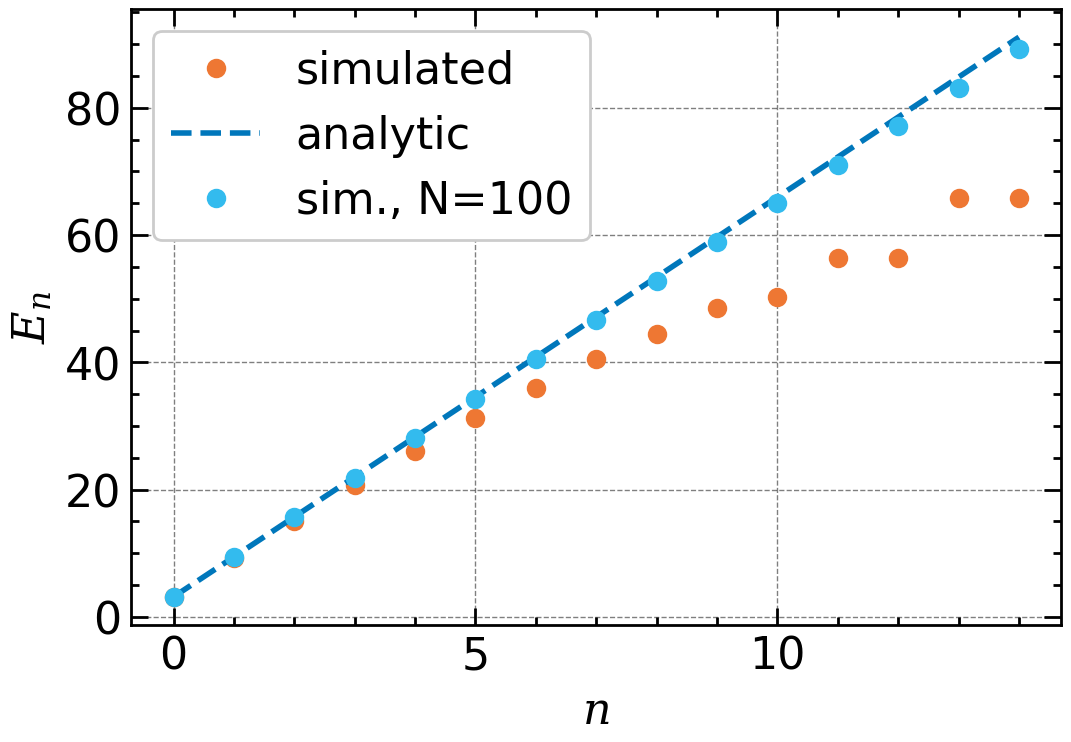

In [7]:
s = SHO_1d_nd(N=30, L=6)
eigs, eigv = sparse.linalg.eigsh(s.H, k=15, which='SM')
eigs = np.sort(eigs)
plt.plot(eigs, 'o', label="simulated")
plt.plot(s.hbar * s.omega * np.arange(0.5, 15.5), '--', label="analytic")
s = SHO_1d_nd(N=100, L=6)
eigs, eigv = sparse.linalg.eigsh(s.H, k=15, which='SM')
eigs = np.sort(eigs)
plt.plot(eigs, 'o', label="sim., N=100")
plt.xlabel("$n$")
plt.ylabel("$E_n$")
plt.legend();

#### 1d Particle in a periodic space

As a second example we take the free particle with periodic boundary conditions, $\psi(x+l) = \psi(x)$. The eigenfunctions are

$$
\psi_n(x) \propto e^{ik_n x}
$$

with $k_n = n 2 \pi / L$.

In [8]:
def Box_1d(N, L, mass=1, hbar=1):
    # kinetic energy
    k = 2 * np.pi * np.fft.fftfreq(N, L/N)
    D2_k = sparse.diags([-k**2], [0])
    D2 = Q_1d(N) @ aslinearoperator(D2_k) @ Q_inv_1d(N)
    T = -(hbar**2 / (2 * mass)) * D2

    H = T
    
    return SimpleNamespace(**locals())

Again we get perfect eigenvalues using the eigendecomposition:

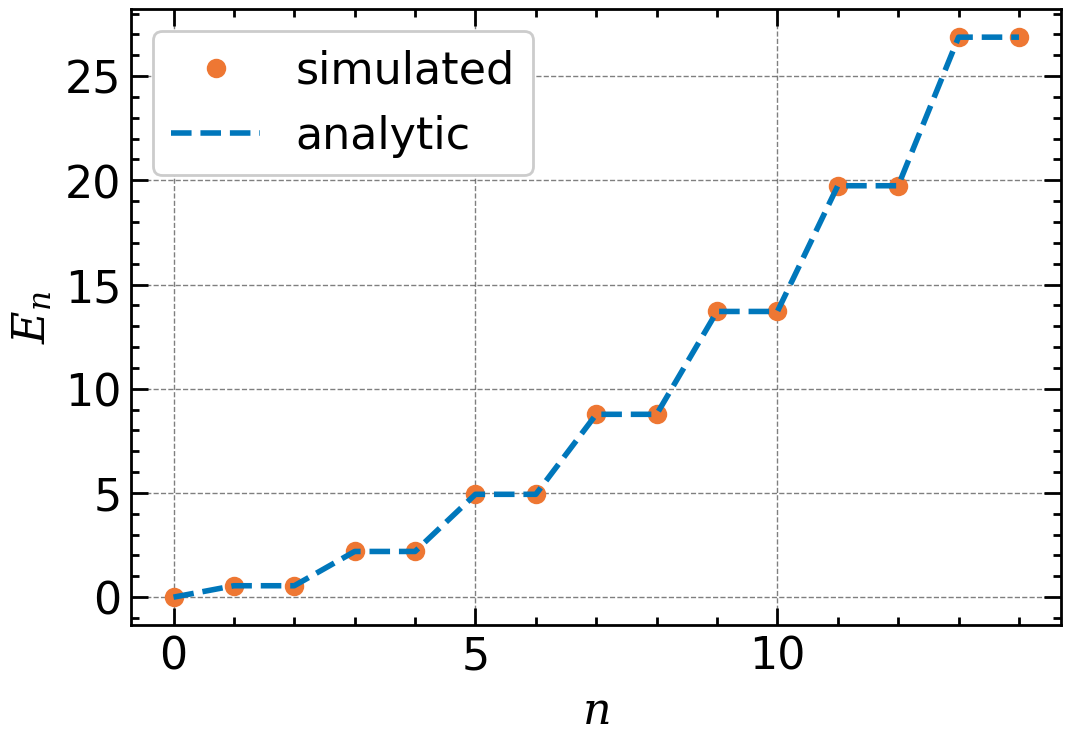

In [9]:
s = Box_1d(N=30, L=6)
eigs, eigv = sparse.linalg.eigsh(s.H, k=15, which='SM')
eigs = np.sort(eigs)
plt.plot(eigs, 'o', label="simulated")
ks = (2 * np.pi / s.L) * np.arange(-7, 8)
ana_eigs = np.sort((s.hbar**2 / (2*s.mass)) * ks**2)
plt.plot(ana_eigs, '--', label="analytic")
plt.xlabel("$n$")
plt.ylabel("$E_n$")
plt.legend();

In [10]:
def Box_1d_nd(N, L, mass=1, hbar=1):
    x = np.linspace(-L/2, L/2, N, endpoint=False)
    # kinetic energy
    dx = np.diff(x)[0]
    D2 = sparse.diags([1, -2, 1, 1, 1], [-1, 0, 1, N-1, -N+1], shape=(N, N)) / dx**2
    T = -(hbar**2 / (2 * mass)) * D2

    H = T
    
    return SimpleNamespace(**locals())

And again for similar quality we need in the non-diagonal version a higher resolution:

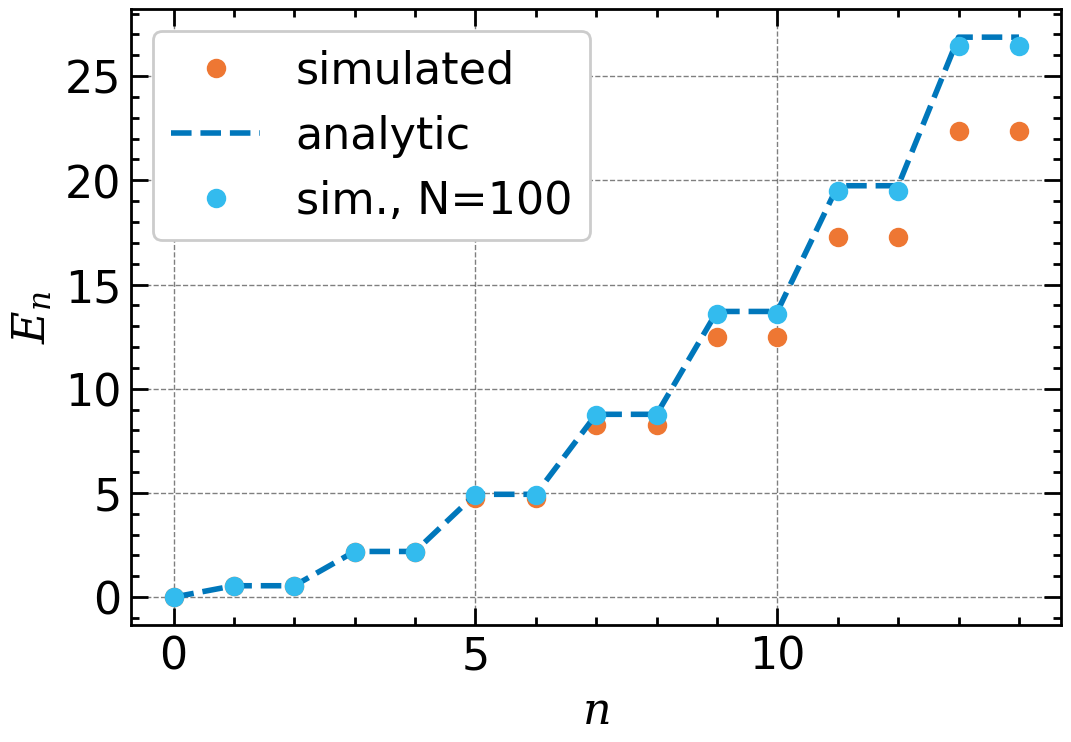

In [11]:
s = Box_1d_nd(N=30, L=6)
eigs, eigv = sparse.linalg.eigsh(s.H, k=15, which='SM')
eigs = np.sort(eigs)
plt.plot(eigs, 'o', label="simulated")
ks = (2 * np.pi / s.L) * np.arange(-7, 8)
ana_eigs = np.sort((s.hbar**2 / (2*s.mass)) * ks**2)
plt.plot(ana_eigs, '--', label="analytic")
s = Box_1d_nd(N=100, L=6)
eigs, eigv = sparse.linalg.eigsh(s.H, k=15, which='SM')
eigs = np.sort(eigs)
plt.plot(eigs, 'o', label="sim., N=100")
plt.xlabel("$n$")
plt.ylabel("$E_n$")
plt.legend();

### 2d Systems

In two dimensions we use the two dimensional `fft` functions and have to `reshape` the `numpy` arrays accordingly:

In [12]:
class Q_inv_2d(sparse.linalg.LinearOperator):

    def __init__(self, N):
        super().__init__(dtype='complex128', shape=(N**2, N**2))
        self.N = N
        
    def _matvec(self, v):
        f = np.reshape(v, (self.N, self.N))
        f_fft = np.fft.fft2(f)
        return np.reshape(f_fft, self.N * self.N)
    
class Q_2d(sparse.linalg.LinearOperator):

    def __init__(self, N):
        super().__init__(dtype='complex128', shape=(N**2, N**2))
        self.N = N
        
    def _matvec(self, v):
        f_fft = np.reshape(v, (self.N, self.N))
        f = np.fft.ifft2(f_fft)
        return np.reshape(f, self.N * self.N)

With this the harmonic oscillator is

In [13]:
def SHO_2d(N, L, mass=1, hbar=1, omega=2*np.pi):
    One = sparse.eye(N)

    # potential energy
    x = np.linspace(-L/2, L/2, N, endpoint=False)
    R2_2d = kron(sparse.diags([x**2], [0]), One) + kron(One, sparse.diags([x**2], [0]))
    V = aslinearoperator(0.5 * mass * omega**2 * R2_2d)

    # kinetic energy
    k = 2 * np.pi * np.fft.fftfreq(N, L/N)
    D2_k_2d = kron(sparse.diags([-k**2], [0]), One) + kron(One, sparse.diags([-k**2], [0]))
    D2_2d = Q_2d(N) @ aslinearoperator(D2_k_2d) @ Q_inv_2d(N)
    T = -(hbar**2 / (2 * mass)) * D2_2d

    H = T + V
    
    return SimpleNamespace(**locals())

and the eigenvalues are again spot on:

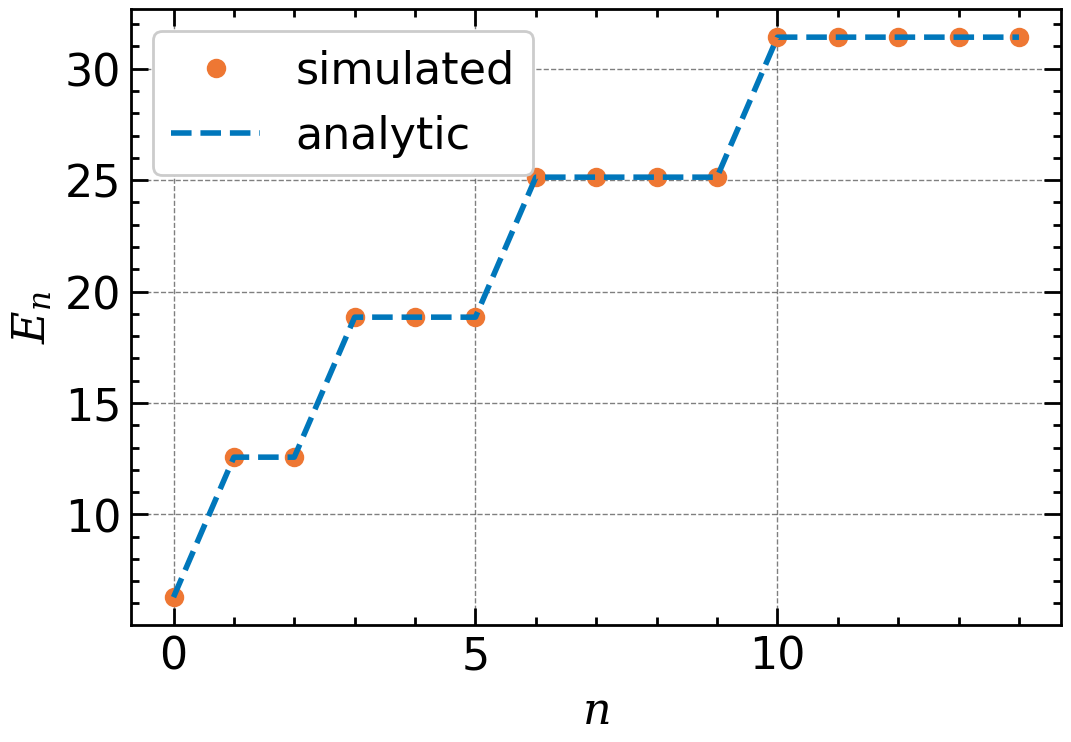

In [14]:
s = SHO_2d(N=30, L=6)
eigs, eigv = sparse.linalg.eigsh(s.H, k=15, which='SM')
eigs = np.sort(eigs)
plt.plot(eigs, 'o', label="simulated")
nx, ny = np.meshgrid(np.arange(0, 5), np.arange(0, 5))
plt.plot(np.sort((s.hbar * s.omega * (nx + ny + 1)).flatten())[:15], '--', label="analytic")
plt.xlabel("$n$")
plt.ylabel("$E_n$")
plt.legend();

For the non-diagonal case:

In [15]:
def SHO_2d_nd(N, L, mass=1, hbar=1, omega=2*np.pi):
    One = sparse.eye(N)

    # potential energy
    x = np.linspace(-L/2, L/2, N, endpoint=False)
    R2_2d = kron(sparse.diags([x**2], [0]), One) + kron(One, sparse.diags([x**2], [0]))
    V = 0.5 * mass * omega**2 * R2_2d

    # kinetic energy
    dx = np.diff(x)[0]
    D2 = sparse.diags([1, -2, 1, 1, 1], [-1, 0, 1, N-1, -N+1], shape=(N, N)) / dx**2
    D2_2d = kron(D2, One) + kron(One, D2)
    T = -(hbar**2 / (2 * mass)) * D2_2d

    H = T + V
    
    return SimpleNamespace(**locals())

Here we again have to use a finer resolution of $N=100$, but note that in the 2d case this means
way more grid points, as the overall vectors scale with $N^2$.

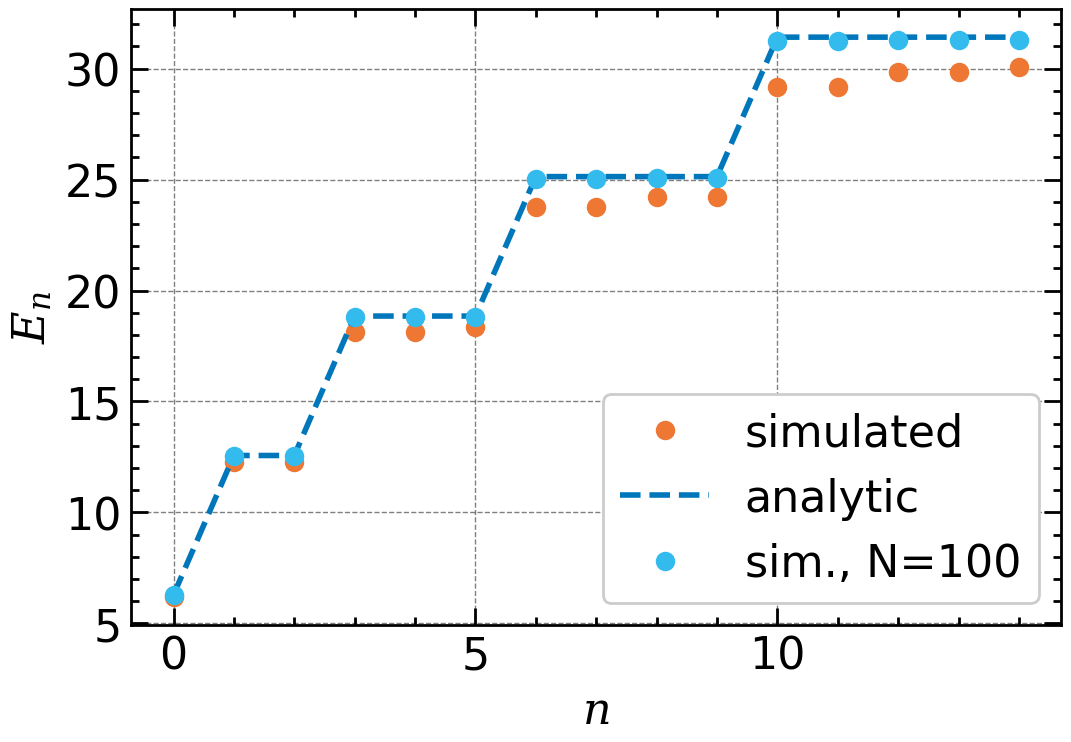

In [16]:
s = SHO_2d_nd(N=30, L=6)
eigs, eigv = sparse.linalg.eigsh(s.H, k=15, which='SM')
eigs = np.sort(eigs)
plt.plot(eigs, 'o', label="simulated")
nx, ny = np.meshgrid(np.arange(0, 5), np.arange(0, 5))
plt.plot(np.sort((s.hbar * s.omega * (nx + ny + 1)).flatten())[:15], '--', label="analytic")
s = SHO_2d_nd(N=100, L=6)
eigs, eigv = sparse.linalg.eigsh(s.H, k=15, which='SM')
eigs = np.sort(eigs)
plt.plot(eigs, 'o', label="sim., N=100")
plt.xlabel("$n$")
plt.ylabel("$E_n$")
plt.legend();

#### 2d particle in periodic space

In [17]:
def Box_2d(N, L, mass=1, hbar=1):
    One = sparse.eye(N)
    # kinetic energy
    k = 2 * np.pi * np.fft.fftfreq(N, L/N)
    D2_k_2d = kron(sparse.diags([-k**2], [0]), One) + kron(One, sparse.diags([-k**2], [0]))
    D2_2d = Q_2d(N) @ aslinearoperator(D2_k_2d) @ Q_inv_2d(N)
    T = -(hbar**2 / (2 * mass)) * D2_2d

    H = T
    
    return SimpleNamespace(**locals())

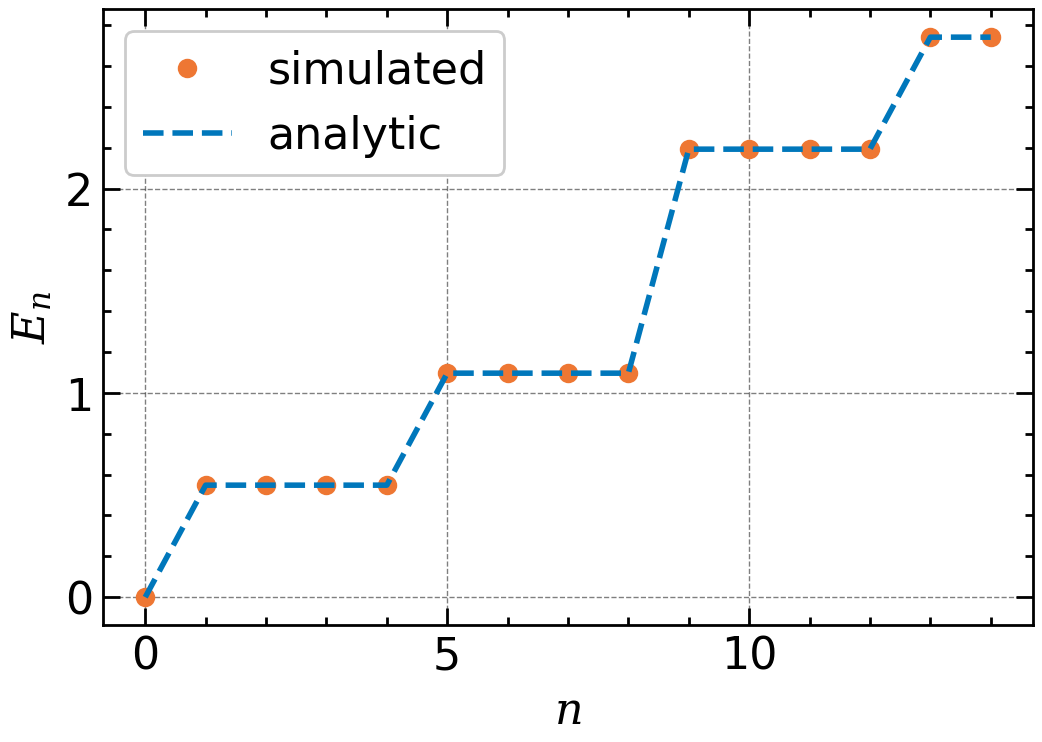

In [18]:
s = Box_2d(N=30, L=6)
eigs, eigv = sparse.linalg.eigsh(s.H, k=15, which='SM')
eigs = np.sort(eigs)
plt.plot(eigs, 'o', label="simulated")

nx, ny = np.meshgrid(np.arange(-5, 5), np.arange(-5, 5))
kx = (2 * np.pi / s.L) * nx
ky = (2 * np.pi / s.L) * ny
ana_eigs = np.sort(((s.hbar**2 / (2*s.mass)) * (kx**2 + ky**2)).flatten())[0:15]

plt.plot(ana_eigs, '--', label="analytic")
plt.xlabel("$n$")
plt.ylabel("$E_n$")
plt.legend();

Non-diagonal form:

In [19]:
def Box_2d_nd(N, L, mass=1, hbar=1):
    One = sparse.eye(N)
    x = np.linspace(-L/2, L/2, N, endpoint=False)
    # kinetic energy
    dx = np.diff(x)[0]
    D2 = sparse.diags([1, -2, 1, 1, 1], [-1, 0, 1, N-1, -N+1], shape=(N, N)) / dx**2
    D2_2d = kron(D2, One) + kron(One, D2)
    T = -(hbar**2 / (2 * mass)) * D2_2d
    H = T
    
    return SimpleNamespace(**locals())

Here the eigenvalues are not as bad as before even for $N=30$.

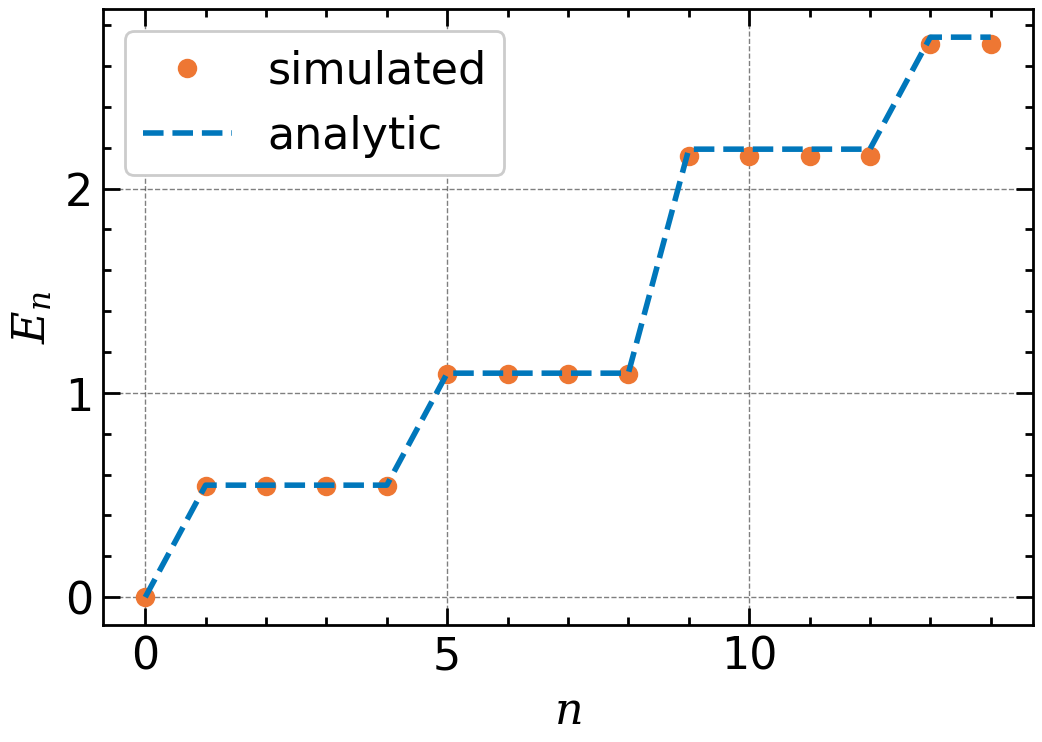

In [20]:
s = Box_2d_nd(N=30, L=6)
eigs, eigv = sparse.linalg.eigsh(s.H, k=15, which='SM')
eigs = np.sort(eigs)
plt.plot(eigs, 'o', label="simulated")

nx, ny = np.meshgrid(np.arange(-5, 5), np.arange(-5, 5))
kx = (2 * np.pi / s.L) * nx
ky = (2 * np.pi / s.L) * ny
ana_eigs = np.sort(((s.hbar**2 / (2*s.mass)) * (kx**2 + ky**2)).flatten())[0:15]

plt.plot(ana_eigs, '--', label="analytic")
plt.xlabel("$n$")
plt.ylabel("$E_n$")
plt.legend();

This seems to be because the overall energies are quite low and therefore the non-diagonal form of the
momentum operator is still in the area where the approximation is valid. This is because the
[eigenvalues](https://znswanderer.github.io/physics/Discrete/) of the $p^2$ operator for low momenta 
in the non-diagonal form are

$$
p^2 = \frac{4N^2 \hbar^2}{L^2}\sin^2 \left( \frac{(n+1) \pi}{2 N} \right)
$$

but the correct values are

$$
p^2 = \frac{(n+1)^2 \pi^2 \hbar^2}{2mL^2}
$$

so for small $p^2$ the non-diagonal version is a valid approximation.

### 3d Systems

Here we have

In [21]:
class Q_inv_3d(sparse.linalg.LinearOperator):

    def __init__(self, N):
        super().__init__(dtype='complex128', shape=(N**3, N**3))
        self.N = N
        
    def _matvec(self, v):
        f = np.reshape(v, (self.N, self.N, self.N))
        f_fft = np.fft.fftn(f)
        return np.reshape(f_fft, self.N**3)
    
class Q_3d(sparse.linalg.LinearOperator):

    def __init__(self, N):
        super().__init__(dtype='complex128', shape=(N**3, N**3))
        self.N = N
        
    def _matvec(self, v):
        f_fft = np.reshape(v, (self.N, self.N, self.N))
        f = np.fft.ifftn(f_fft)
        return np.reshape(f, self.N**3)

In [22]:
def SHO_3d(N, L, mass=1, hbar=1, omega=2*np.pi):
    One = sparse.eye(N)

    # potential energy
    x = np.linspace(-L/2, L/2, N, endpoint=False)
    R2_1d = sparse.diags([x**2], [0])
    R2_3d = kron(kron(R2_1d, One), One) + kron(kron(One, R2_1d), One) + kron(kron(One, One), R2_1d)
    V = aslinearoperator(0.5 * mass * omega**2 * R2_3d)

    # kinetic energy
    k = 2 * np.pi * np.fft.fftfreq(N, L/N)
    D2_k_1d = sparse.diags([-k**2], [0])
    D2_k_3d = kron(kron(D2_k_1d, One), One) + kron(kron(One, D2_k_1d), One) + kron(kron(One, One), D2_k_1d)
    D2_3d = Q_3d(N) @ aslinearoperator(D2_k_3d) @ Q_inv_3d(N)
    T = -(hbar**2 / (2 * mass)) * D2_3d

    H = T + V
    
    return SimpleNamespace(**locals())

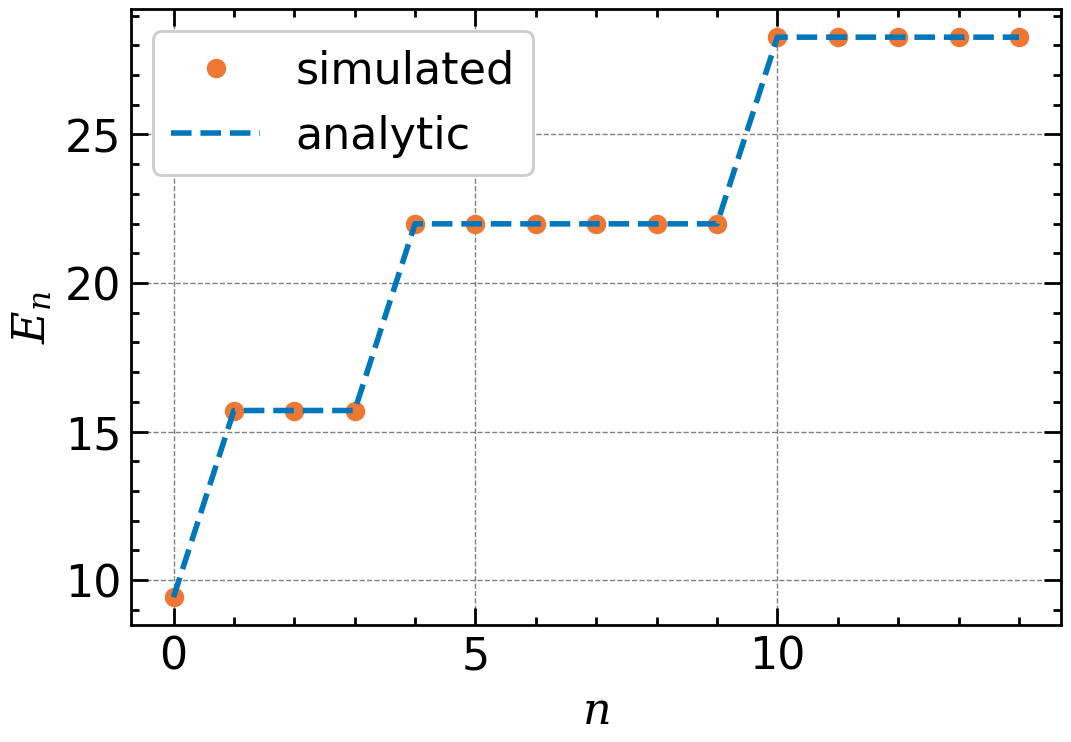

In [23]:
s = SHO_3d(N=30, L=6)
eigs, eigv = sparse.linalg.eigsh(s.H, k=15, which='SM')
eigs = np.sort(eigs)
plt.plot(eigs, 'o', label="simulated")
nx, ny, nz = np.meshgrid(np.arange(0, 5), np.arange(0, 5), np.arange(0, 5))
plt.plot(np.sort((s.hbar * s.omega * (nx + ny + nz + 1.5)).flatten())[:15], '--', label="analytic")
plt.xlabel("$n$")
plt.ylabel("$E_n$")
plt.legend();

And for the non-diagonal form:

In [24]:
def SHO_3d_nd(N, L, mass=1, hbar=1, omega=2*np.pi):
    One = sparse.eye(N)

    # potential energy
    x = np.linspace(-L/2, L/2, N, endpoint=False)
    R2_1d = sparse.diags([x**2], [0])
    R2_3d = kron(kron(R2_1d, One), One) + kron(kron(One, R2_1d), One) + kron(kron(One, One), R2_1d)
    V = 0.5 * mass * omega**2 * R2_3d

    # kinetic energy
    k = 2 * np.pi * np.fft.fftfreq(N, L/N)
    dx = np.diff(x)[0]
    D2 = sparse.diags([1, -2, 1, 1, 1], [-1, 0, 1, N-1, -N+1], shape=(N, N)) / dx**2
    D2_3d = kron(kron(D2, One), One) + kron(kron(One, D2), One) + kron(kron(One, One), D2)
    T = -(hbar**2 / (2 * mass)) * D2_3d

    H = T + V
    
    return SimpleNamespace(**locals())

The simulation for $N=100$ now takes a serious amount if time, because the overall vectors
scale with $N^3$:

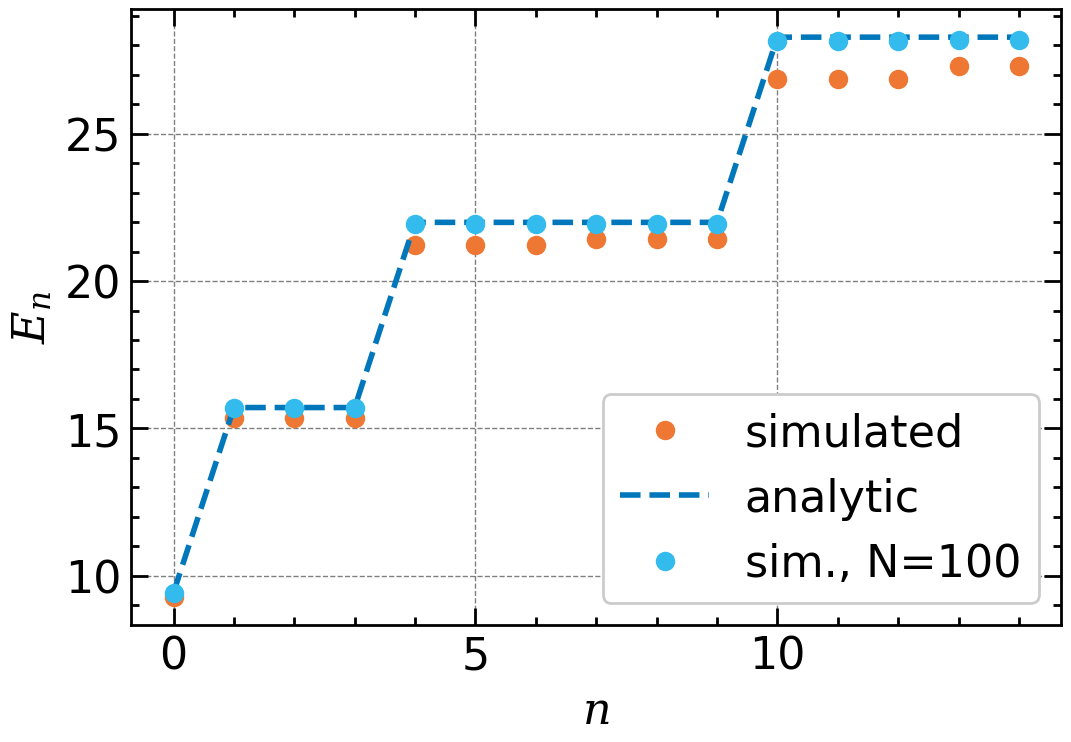

In [25]:
s = SHO_3d_nd(N=30, L=6)
eigs, eigv = sparse.linalg.eigsh(s.H, k=15, which='SM')
eigs = np.sort(eigs)
plt.plot(eigs, 'o', label="simulated")
nx, ny, nz = np.meshgrid(np.arange(0, 5), np.arange(0, 5), np.arange(0, 5))
plt.plot(np.sort((s.hbar * s.omega * (nx + ny + nz + 1.5)).flatten())[:15], '--', label="analytic")

s = SHO_3d_nd(N=100, L=6)
eigs, eigv = sparse.linalg.eigsh(s.H, k=15, which='SM')
eigs = np.sort(eigs)
plt.plot(eigs, 'o', label="sim., N=100")
plt.xlabel("$n$")
plt.ylabel("$E_n$")
plt.legend();

#### 3d particle in periodic space

In [26]:
def Box_3d(N, L, mass=1, hbar=1, omega=2*np.pi):
    One = sparse.eye(N)

    # kinetic energy
    k = 2 * np.pi * np.fft.fftfreq(N, L/N)
    D2_k_1d = sparse.diags([-k**2], [0])
    D2_k_3d = kron(kron(D2_k_1d, One), One) + kron(kron(One, D2_k_1d), One) + kron(kron(One, One), D2_k_1d)
    D2_3d = Q_3d(N) @ aslinearoperator(D2_k_3d) @ Q_inv_3d(N)
    T = -(hbar**2 / (2 * mass)) * D2_3d

    H = T
    
    return SimpleNamespace(**locals())

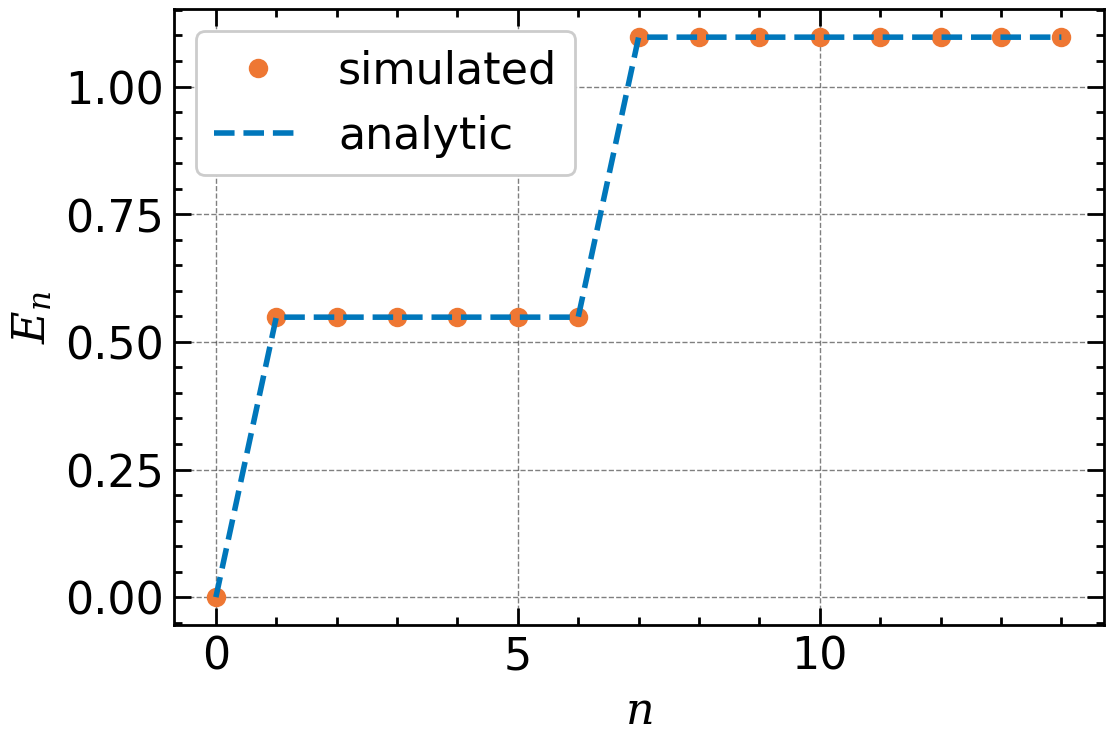

In [27]:
s = Box_3d(N=30, L=6)
eigs, eigv = sparse.linalg.eigsh(s.H, k=15, which='SM')
eigs = np.sort(eigs)
plt.plot(eigs, 'o', label="simulated")

nx, ny, nz = np.meshgrid(np.arange(-5, 5), np.arange(-5, 5), np.arange(-5, 5))
kx = (2 * np.pi / s.L) * nx
ky = (2 * np.pi / s.L) * ny
kz = (2 * np.pi / s.L) * nz
ana_eigs = np.sort(((s.hbar**2 / (2*s.mass)) * (kx**2 + ky**2 + kz**2)).flatten())[0:15]

plt.plot(ana_eigs, '--', label="analytic")
plt.xlabel("$n$")
plt.ylabel("$E_n$")
plt.legend();

and finally the non-diagonal momentum operator:

In [28]:
def Box_3d_nd(N, L, mass=1, hbar=1, omega=2*np.pi):
    One = sparse.eye(N)
    x = np.linspace(-L/2, L/2, N, endpoint=False)

    # kinetic energy
    k = 2 * np.pi * np.fft.fftfreq(N, L/N)
    dx = np.diff(x)[0]
    D2 = sparse.diags([1, -2, 1, 1, 1], [-1, 0, 1, N-1, -N+1], shape=(N, N)) / dx**2
    D2_3d = kron(kron(D2, One), One) + kron(kron(One, D2), One) + kron(kron(One, One), D2)
    T = -(hbar**2 / (2 * mass)) * D2_3d
    H = T
    
    return SimpleNamespace(**locals())

Here again the approximation of the real energies is very good, because the overall (kinetic) energies are low:

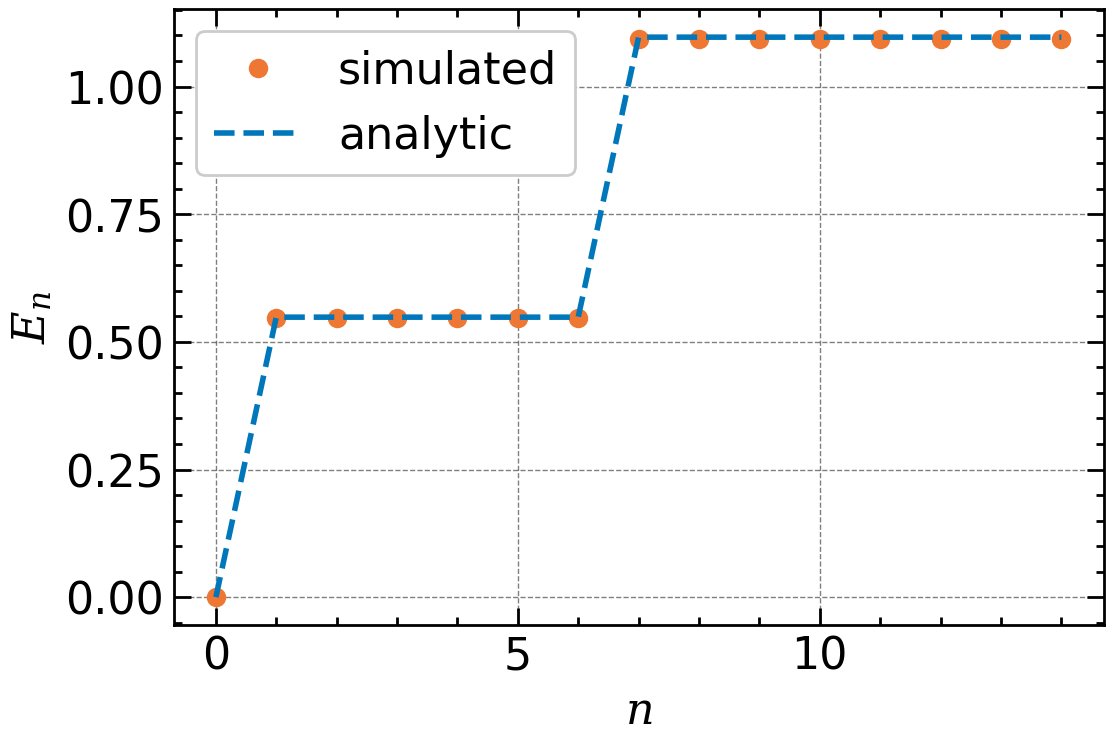

In [29]:
s = Box_3d_nd(N=30, L=6)
eigs, eigv = sparse.linalg.eigsh(s.H, k=15, which='SM')
eigs = np.sort(eigs)
plt.plot(eigs, 'o', label="simulated")

nx, ny, nz = np.meshgrid(np.arange(-5, 5), np.arange(-5, 5), np.arange(-5, 5))
kx = (2 * np.pi / s.L) * nx
ky = (2 * np.pi / s.L) * ny
kz = (2 * np.pi / s.L) * nz
ana_eigs = np.sort(((s.hbar**2 / (2*s.mass)) * (kx**2 + ky**2 + kz**2)).flatten())[0:15]

plt.plot(ana_eigs, '--', label="analytic")
plt.xlabel("$n$")
plt.ylabel("$E_n$")
plt.legend();